### Download and explore data

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents = True, exist_ok= True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path = "datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [2]:
housing.head() #look at the first 5 rows of data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Use info() to get description of data. It is observed that total_bedrooms has missing values.

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Look at ocean_proximity attribute, which is a text attribute. See how many categories there are and how many districts belong to each one.

In [4]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

describe() provides summary of numerical attributes.

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Plot the data. Note that median_income, median_house_value, and housing_median_age are capped. The median_house_value cap can be an issue as the algoirthm may learn that prices never go beyond the limit. There are two options: 
<ul> 
<li> Collect proper labels for districts whose labels were capped </li> 
<li> Remove those districts from the training and test set.</li>
</ul>

Many histograms are also skewed right, which may make it harder for algorithms to detect patterns. Can transform these attributes to have more symmetrical and bell-shaped distributions.

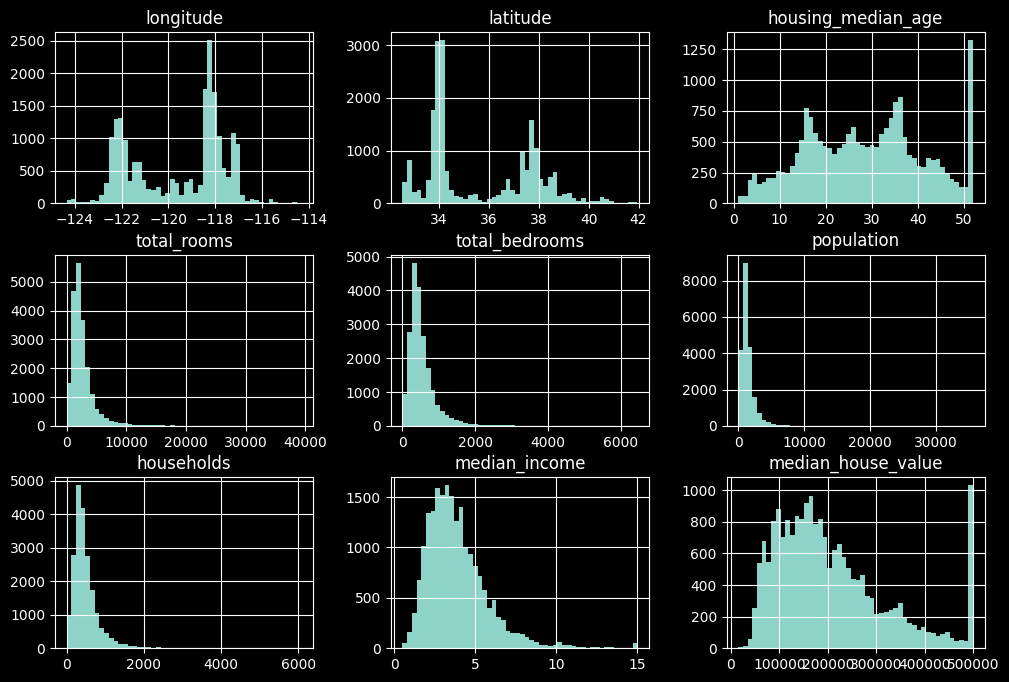

In [6]:
import matplotlib.pyplot as plt 
housing.hist(bins = 50, figsize = (12,8))
plt.show()

### Create a test set

In [7]:
from sklearn.model_selection import train_test_split
import numpy as np
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42) # train-test split 80:20

Median income is a very important attribute in predicting housing prices. Need to ensure the test set is representative of the various categories of incomes in the whole dataset. This can be done with stratified sampling. <br> <br> First, create an income category attribute.

In [8]:
housing["income_cat"] = pd.cut(housing["median_income"], bins = [0., 1.5, 3.0, 4.5, 6., np.inf], labels = [1, 2, 3, 4, 5])

Plot the categorical attribute.

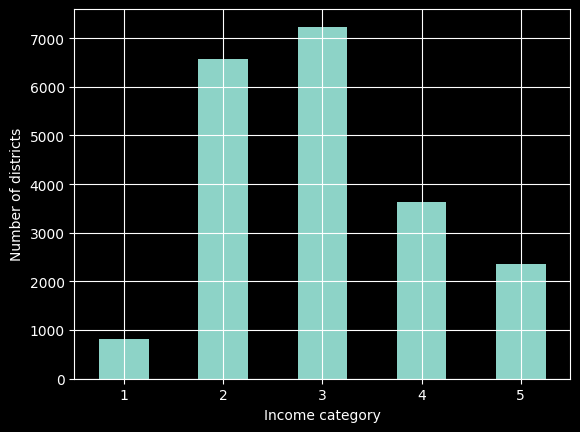

In [9]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot = 0, grid = True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

Generate 10 different stratified splits using the categorical income attribute.

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

Use the first split.

In [11]:
strat_train_set, strat_test_set = strat_splits[0]

Alternative method. The test set generated has proportions identical to the full dataset in terms of median income. 

In [12]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

Scrap the income_cat column and revert data to original state.

In [13]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis = 1, inplace = True)

### Explore and visualize the data to gain insights

Make a copy of original data so it can be reverted at the end.

In [14]:
housing = strat_train_set.copy()

<b> Visualize geographical data. </b> <br><br> The high-density areas include the Bay Area, LA and SD, as well as the Central Valley. 

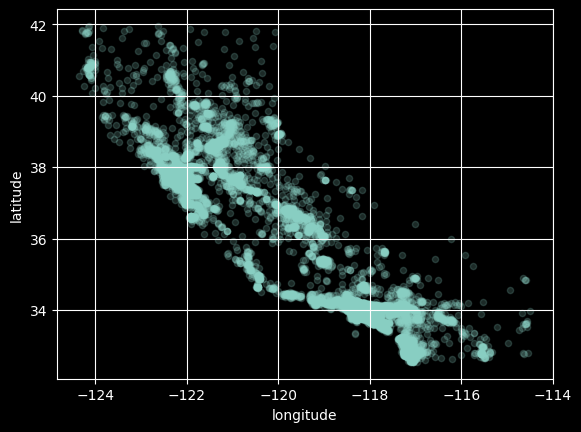

In [15]:
housing.plot(kind = "scatter", x = "longitude", y="latitude", grid = True, alpha = 0.2)
plt.show()

Look at housing prices. Radius of each dot represents population size, and color represents price. It is observed that the price is related to the location and population density.

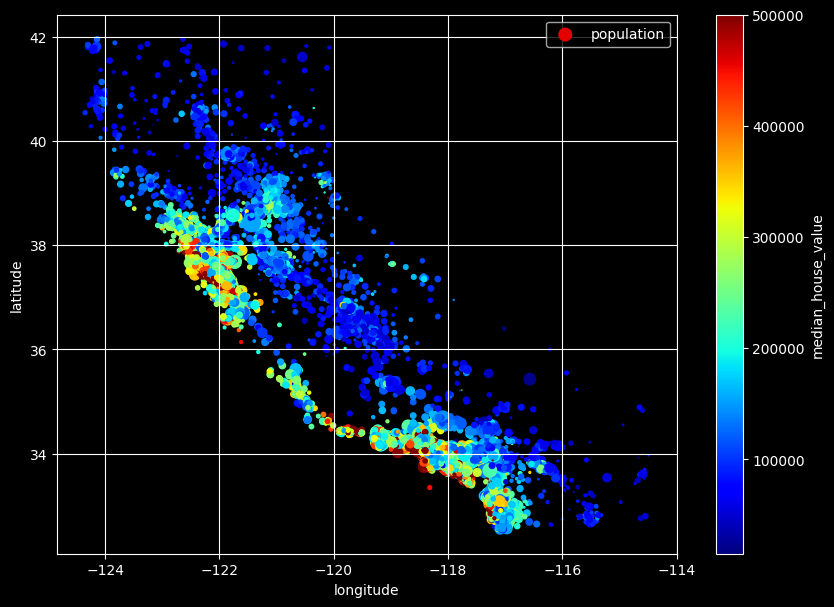

In [16]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", grid = True, 
             s = housing["population"] / 100, label = "population",
             c = "median_house_value", cmap = "jet", colorbar = True,
             legend = True, sharex = False, figsize = (10,7))
plt.show()

### Look for correlations

In [17]:
corr_matrix = housing[["median_house_value", "median_income", "total_rooms", "housing_median_age", "households", "total_bedrooms", "population", "longitude", "latitude"]].corr()

Observe how much each attribute correlates with median house value. There is a strong positive correlation between median income and median house value. On the other hand, there is a negative correlation between latitude and median house value.

In [18]:
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

Alternative method: Use scatter_matrix(), which plots every numerical attribute against every other numerical attribute. We see that there is a strong linear relationship between median income and median house value.

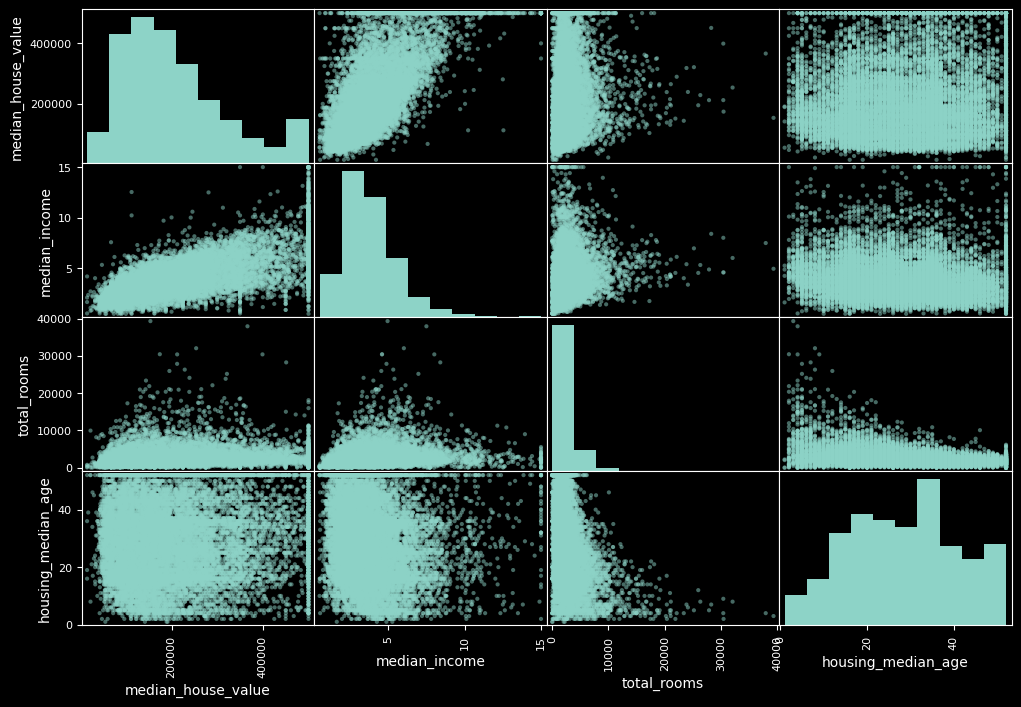

In [19]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", 
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize = (12,8))
plt.show()

Upon closer examination, the price cap is clearly visible at 500,000. There are also less obvious horizontal lines, as seen at 350,000 and 450,000.

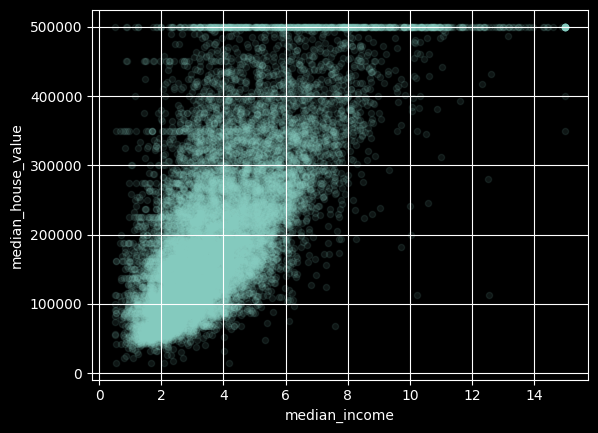

In [20]:
housing.plot(kind = "scatter", x = "median_income", y = "median_house_value", alpha = 0.1, grid = True)
plt.show()


### Experiment with Attribute Combinations

The total number of rooms and bedrooms, and population isn't exactly helpful; the ratio of rooms per house, bedroom/room ratio, and people per house are better choices.

In [21]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

Looking at the correlation matrix,  rooms_per_house is more informative than total number of rooms. Houses with a lower bedroom/room ratio are more expensive generally. 

In [22]:
corr_matrix = housing.drop("ocean_proximity", axis = 1).corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

### Prepare the Data for Machine Learning Algorithms

In [23]:
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set['median_house_value'].copy()

### Clean the data

Use an imputer to fill in the missing values in total_bedrooms with the median.

In [24]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = "median")

Grab all numerical attributes.

In [25]:
housing_num = housing.select_dtypes(include = [np.number])

Fit the imputer to the training data.

In [26]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [27]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [28]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

Use the trained imputer to transform the training set by replacing missing values with the learned medians.

In [29]:
x = imputer.transform(housing_num)

In [30]:
housing_tr = pd.DataFrame(x, columns = housing_num.columns, index = housing_num.index)

### Handling Text and Categorical Attributes

In [31]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


Use a one-hot encoder to transform the text categorical attribute such that only one attribute will equal 1 while the rest will be 0.

In [32]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [33]:
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Convert to dense numpy array.

In [34]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

### Feature Scaling and Transformation

Min-max scaling: $$ \frac{val - min}{max - min} $$

In [35]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range = (-1, 1)) #set feature range hyperparameter to [-1, 1]
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num) #fit and transform the numerical attributes of housing with the learned normalization.

Standardization: $$ \frac{val - min}{std} $$ <br> Standardization handles outliers better than normalization does.

In [36]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

For features with a multimodal distribution such as housing median age, add a feature to each mode representing the similarity between the housing median age and particular mode. Typically computed with a radial basis function (RBF). The gamma hyperparameter determins how quickly the similarity measure decays as x moves away from 35.

In [37]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma = 0.1)

After scaling the target values, and then feeding it to the regression model to make predictions on some new data, an inverse transformer is used such that the predictions will be on the original scale. 

In [38]:
from sklearn.linear_model import LinearRegression
target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing [["median_income"]].iloc[:5]

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

Alternative method: Construct a TransformedTargetRegressor.

In [39]:
from sklearn.compose import TransformedTargetRegressor
model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

Transform features with heavy-tailed distributedions with a logarithmic scale.

In [40]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func = np.exp)
log_pop = log_transformer.transform(housing[["population"]])

In [41]:
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35.]], gamma = 0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [42]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel, kw_args = dict(Y=[sf_coords], gamma = 0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

Example of a ratio transformer that computes the ratio between input features 0 and 1.

In [43]:
ratio_transfomrer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transfomrer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

Example of a custom transformer with StandardScaler behavior.

In [44]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean = True):
        self.with_mean = with_mean

    def fit(self, X, y = None):
        X = check_array(X)
        self.mean_  = X.mean(axis = 0)
        self.scale_ = X.std(axis = 0)
        self.n_features_in_ = X.shape[1]
        return self
    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in == X.shape[1]
        if self.with_mean:
            X  = X - self.mean_
        return X / self.scale_

This custom transformer uses a KMeans clusterer to identify the main clusters in the training data, and then uses rbf_kernel() to measure how similar each sample is to each cluster center.

In [45]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters = 10, gamma = 1.0, random_state = None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y = None, sample_weight = None):
        self.kmeans_ = KMeans(self.n_clusters, random_state= self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma = self.gamma)
    
    def get_feature_names_out(self, names = None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]
    

This is a cluster similarity transformer, setting number of clusters to 10. Then it calls fit_transform with the latitutde and longitude of every district in the training set, and weighs each district by the target value. Uses k-means to locate clusters, then measures Gaussian RBF similarity between each district and all 10 cluster centers.

In [46]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma = 1., random_state= 42)
similarities = cluster_simil.fit_transform(housing[['latitude', 'longitude']], sample_weight = housing_labels)

/Users/ahhussain1017/PythonScripts/ML/ML-Notes/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [47]:
similarities[:3].round(2)

array([[0.08, 0.  , 0.6 , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.14],
       [0.  , 0.99, 0.  , 0.04, 0.  , 0.  , 0.11, 0.  , 0.63, 0.  ],
       [0.44, 0.  , 0.3 , 0.  , 0.  , 0.7 , 0.  , 0.01, 0.  , 0.29]])

### Transformation Pipelines

Example of simple pipeline:

In [48]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([("impute", SimpleImputer(strategy="median")), ("standardize", StandardScaler())])

Alternative method:

In [49]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [50]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

Recover a dataframe from the result:

In [51]:
df_housing_num_prepared = pd.DataFrame(housing_num_prepared, columns=num_pipeline.get_feature_names_out(), index = housing_num.index)

A ColumnTransformer makes it possible to have a single transformer handle both categorical and numerical attributes together.

In [52]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(SimpleImputer(strategy = "most_frequent"), OneHotEncoder(handle_unknown="ignore"))
preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

An easier way of passing in the the columns is using make_column_selector:

In [53]:
from sklearn.compose import make_column_transformer, make_column_selector

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include = np.number)), 
    (cat_pipeline, make_column_selector(dtype_include=object))
)

Apply the ColumnTransformer to the housing data:

In [54]:
housing_prepared = preprocessing.fit_transform(housing)

Final pipeline with all transformations:

In [55]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]

def ratio_pipeline():
    return make_pipeline(SimpleImputer(strategy="median"), 
                         FunctionTransformer(column_ratio, feature_names_out=ratio_name),
                         StandardScaler())

log_pipeline = make_pipeline(SimpleImputer(strategy="median"), 
                             FunctionTransformer(np.log, feature_names_out="one-to-one"),
                             StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters= 10, gamma = 1., random_state= 42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ['total_bedrooms', 'total_rooms']),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", 'households']),
    ('people_per_house', ratio_pipeline(), ['population', 'households']),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", 'median_income']),
    ("geo", cluster_simil, ['latitude', 'longitude']),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
],
remainder = default_num_pipeline)

In [56]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

/Users/ahhussain1017/PythonScripts/ML/ML-Notes/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(16512, 24)

In [57]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

### Select and Train a Model

Train and Evaluate on the training set

In [58]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

/Users/ahhussain1017/PythonScripts/ML/ML-Notes/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x14e...
                                                   'households',
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x14ec8e2f0>)])),
                ('linearregression', LinearRegression())])

In [59]:
housing_predictions = lin_reg.predict(housing)

In [60]:
housing_predictions[:5].round(-2)

array([242800., 375900., 127500.,  99400., 324600.])

In [61]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

Some predictions are quite off. Measure error using root mean squared error (RMSE).

In [62]:
from sklearn.metrics import mean_squared_error
lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared = False)
lin_rmse

68647.95686706656

This is an instance of underfitting. 
Possible solutions: <ul> <li> select a more powerful model </li> <li> feed better features </li> <li> reduce constraints on the model </li> <br>
This model isn't regularized ruling out the last option. Try a different model.

In [63]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

/Users/ahhussain1017/PythonScripts/ML/ML-Notes/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x14e...
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x14ec8e2f0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [64]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions, squared = False)
tree_rmse

0.0

In [65]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels, 
                              scoring = "neg_root_mean_squared_error", cv = 10)


/Users/ahhussain1017/PythonScripts/ML/ML-Notes/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ahhussain1017/PythonScripts/ML/ML-Notes/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ahhussain1017/PythonScripts/ML/ML-Notes/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ahhussain1017/PythonScripts/ML/ML-Notes/myenv/lib/p

As observed, decision trees don't perform much better than linear regression does, and there is severe overfitting.

In [66]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     67153.318273
std       1963.580924
min      63925.253106
25%      66083.277180
50%      66795.829871
75%      68074.018403
max      70664.635833
dtype: float64

Try random forests:

In [67]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels, 
                                scoring = "neg_root_mean_squared_error", cv = 10)

/Users/ahhussain1017/PythonScripts/ML/ML-Notes/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ahhussain1017/PythonScripts/ML/ML-Notes/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ahhussain1017/PythonScripts/ML/ML-Notes/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ahhussain1017/PythonScripts/ML/ML-Notes/myenv/lib/p

Random forests does considerably better, but there is still overfitting.

In [68]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     47002.931706
std       1048.451340
min      45667.064036
25%      46494.358345
50%      47093.173938
75%      47274.873814
max      49354.705514
dtype: float64

### Fine-Tune Model

Grid search uses cross-validation to evaluate all possible combinations of hyperparameter values. This is an example with the random forest regressor.

In [69]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([("preprocessing", preprocessing), 
                          ("random_forest", RandomForestRegressor(random_state=42))])
param_grid = [
    {'preprocessing__geo__n_clusters': [5,8,10],
     'random_forest__max_features': [4,6,8]},
     {'preprocessing__geo__n_clusters':[10, 15],
      'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv = 3, scoring = 'neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

/Users/ahhussain1017/PythonScripts/ML/ML-Notes/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ahhussain1017/PythonScripts/ML/ML-Notes/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ahhussain1017/PythonScripts/ML/ML-Notes/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ahhussain1017/PythonScripts/ML/ML-Notes/myenv/lib/p

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x14ec8e2f0>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In this case, the best model is obstained by setting n_clusters to 15 and max_features to 6.

In [70]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [71]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace = True)

In [72]:
[...]

[Ellipsis]

In [73]:
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
12,3.589106,0.097214,0.088261,0.001324,15,6,"{'preprocessing__geo__n_clusters': 15, 'random...",-43535.728124,-43753.147171,-44568.889283,-43952.588193,444.738152,1
13,4.410849,0.035012,0.086810,0.000254,15,8,"{'preprocessing__geo__n_clusters': 15, 'random...",-44084.115907,-44204.924326,-44862.665796,-44383.902009,342.110841,2
14,5.406632,0.034371,0.088241,0.001379,15,10,"{'preprocessing__geo__n_clusters': 15, 'random...",-44367.841163,-44496.254950,-45199.975902,-44688.024005,365.780976,3
7,3.401579,0.020771,0.086263,0.000218,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44250.873441,-44628.321123,-45857.123289,-44912.105951,685.764787,4
9,3.411673,0.019819,0.087384,0.000424,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44250.873441,-44628.321123,-45857.123289,-44912.105951,685.764787,4


Randomized Search

In [74]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low = 3, high = 50),
                  'random_forest__max_features': randint(low = 2, high = 20)}

rnd_search = RandomizedSearchCV(full_pipeline, param_distributions=param_distribs, n_iter = 10, cv = 3,
                                scoring = 'neg_root_mean_squared_error', random_state=42)
rnd_search.fit(housing, housing_labels)

/Users/ahhussain1017/PythonScripts/ML/ML-Notes/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ahhussain1017/PythonScripts/ML/ML-Notes/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ahhussain1017/PythonScripts/ML/ML-Notes/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ahhussain1017/PythonScripts/ML/ML-Notes/myenv/lib/p

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x14ec8e2f0>)])),
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14ef52d40>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14ef33c40>},
                   random_state=42, scoring='neg_root_mean_squared_error')

Analyzing the Best Models and Their Errors

In [75]:
final_model = rnd_search.best_estimator_
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.06, 0.06, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.01, 0.01, 0.02,
       0.04, 0.01, 0.  , 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.  ,
       0.01, 0.  , 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.03, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.02, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.08,
       0.  , 0.  , 0.  , 0.01])

In [76]:
sorted(zip(feature_importances, 
           final_model["preprocessing"].get_feature_names_out()),
           reverse = True)

[(0.1898423270105783, 'log__median_income'),
 (0.07709175866873944, 'cat__ocean_proximity_INLAND'),
 (0.06455488601956336, 'bedrooms__ratio'),
 (0.056936146643377976, 'rooms_per_house__ratio'),
 (0.0490294770805355, 'people_per_house__ratio'),
 (0.03807069074492323, 'geo__Cluster 3 similarity'),
 (0.025643913400094476, 'geo__Cluster 22 similarity'),
 (0.02179127543243723, 'geo__Cluster 17 similarity'),
 (0.021575251507503695, 'geo__Cluster 6 similarity'),
 (0.017868654556924362, 'geo__Cluster 2 similarity'),
 (0.017431400050755975, 'geo__Cluster 32 similarity'),
 (0.015981159400591683, 'geo__Cluster 18 similarity'),
 (0.01488846425739688, 'geo__Cluster 40 similarity'),
 (0.014488389218107143, 'geo__Cluster 43 similarity'),
 (0.014252940099964142, 'geo__Cluster 7 similarity'),
 (0.014038173319370725, 'geo__Cluster 21 similarity'),
 (0.013846025114732157, 'geo__Cluster 38 similarity'),
 (0.01362570996472274, 'geo__Cluster 34 similarity'),
 (0.013547297167034428, 'geo__Cluster 41 similari

### Evaluate system on test set

In [77]:
X_test = strat_test_set.drop("median_house_value", axis = 1)
y_test = strat_test_set["median_house_value"].copy()
final_predictions = final_model.predict(X_test)
final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

41549.20158097943


In [78]:
from scipy import stats
confidence = .95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, 
                         loc = squared_errors.mean(), 
                         scale = stats.sem(squared_errors)))

array([39395.35475927, 43596.76969025])

### Launch, monitor, and maintain system

In [79]:
import joblib
joblib.dump(final_model, "my_california_housing_model.pkl")

['my_california_housing_model.pkl']